In [1]:
import geopandas as gpd
from shapely.geometry import Point, shape
from dem_stitcher.geojson_io import read_geojson_gzip
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from pathlib import Path
import concurrent.futures
from tqdm import tqdm
import requests

In [89]:
BURST_ID = 'T064-135524-IW1'.upper().replace('-', '_')

# Select Point

In [90]:
BUST_ID_TABLE = BURST_ID.lower().replace('-', '_')
BUST_ID_TABLE

't064_135524_iw1'

In [91]:
df_bursts = read_geojson_gzip('opera_burst_ids.geojson.zip')
df_bursts.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


In [92]:
df_burst = df_bursts[df_bursts.burst_id_jpl == BUST_ID_TABLE].reset_index(drop=True)
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((-119.00699 34.67196, -118.07701 34.8...",t064_135524_iw1,1,True,ASCENDING


<Axes: >

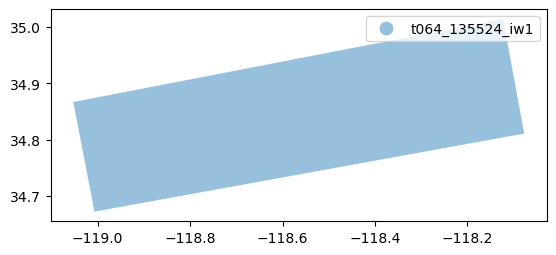

In [93]:
fig, ax = plt.subplots()
df_burst.plot(column='burst_id_jpl', categorical=True, alpha=.5, legend=True, cmap='tab20c', ax=ax)

# Create data directory

In [94]:
ts_dir = Path('burst_time_series')
burst_dir = ts_dir / BURST_ID

burst_dir.mkdir(exist_ok=True, parents=True)
burst_dir

PosixPath('burst_time_series/T064_135524_IW1')

# Download Burst Time Series

In [95]:
import asf_search as asf

# get only the RTC products for a burst id
resp = asf.search(operaBurstID=[BURST_ID], processingLevel='RTC')
assert resp

In [96]:
properties = [r.properties for r in resp]
geometry = [shape(r.geojson()['geometry']) for r in resp]
properties_f = [{'opera_id': p['sceneName'], 
                 'start_time': p['startTime'],
                 'polarization': p['polarization'],
                 'url_vh': p['url'], 
                 'url_vv': (p['url'].replace('_VH.tif', '_VV.tif')),
                 'track_number': p['pathNumber']} for p in properties]

df = gpd.GeoDataFrame(properties_f, geometry=geometry, crs=CRS.from_epsg(4326))
df = df.sort_values(by='start_time')
df.drop(columns=['polarization'], inplace=True)
print(df.shape)
df.head()

(115, 6)


,opera_id,start_time,url_vh,url_vv,track_number,geometry
114,OPERA_L2_RTC-S1_T064-135524-IW1_20200229T01503...,2020-02-29T01:50:38Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-118.98182 34.68055, -118.04924 34.8..."
113,OPERA_L2_RTC-S1_T064-135524-IW1_20200312T01503...,2020-03-12T01:50:38Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-118.98250 34.68103, -118.04995 34.8..."
112,OPERA_L2_RTC-S1_T064-135524-IW1_20200324T01503...,2020-03-24T01:50:38Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-118.98190 34.68043, -118.04933 34.8..."
111,OPERA_L2_RTC-S1_T064-135524-IW1_20200417T01503...,2020-04-17T01:50:39Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-118.98167 34.68114, -118.04926 34.8..."
110,OPERA_L2_RTC-S1_T064-135524-IW1_20200429T01504...,2020-04-29T01:50:40Z,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,"POLYGON ((-118.98164 34.68052, -118.04921 34.8..."


In [97]:
opera_ids = df.opera_id.tolist()

opera_prod_dirs = [burst_dir / oid for oid in opera_ids]
opera_prod_dirs[:2]

[PosixPath('burst_time_series/T064_135524_IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0'),
 PosixPath('burst_time_series/T064_135524_IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20200312T015038Z_20230928T223447Z_S1A_30_v1.0')]

In [98]:
def download_one_file(url: str, dest_dir: Path):
    """source: https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests"""
    dest_dir.mkdir(exist_ok=True, parents=True)
    local_filename = url.split('/')[-1]
    out_path = dest_dir / local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(out_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)
    return out_path


def download_one_file_star(input_data):
    return download_one_file(*input_data)

In [99]:
zipped_inputs_vv = list(zip(df.url_vv.tolist(), opera_prod_dirs))
zipped_inputs_vv[0]

('https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0_VV.tif',
 PosixPath('burst_time_series/T064_135524_IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0'))

In [100]:
zipped_inputs_vh = list(zip(df.url_vh.tolist(), opera_prod_dirs))
zipped_inputs_vh[0]

('https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0_VH.tif',
 PosixPath('burst_time_series/T064_135524_IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0'))

In [101]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths_vh = list(tqdm(executor.map(download_one_file_star, zipped_inputs_vh[:]), total=len(zipped_inputs_vh)))

100%|██████████████████████████████████████████████████████████████████| 115/115 [01:28<00:00,  1.30it/s]


In [102]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    out_paths_vv = list(tqdm(executor.map(download_one_file_star, zipped_inputs_vv[:]), total=len(zipped_inputs_vv)))

100%|██████████████████████████████████████████████████████████████████| 115/115 [01:26<00:00,  1.33it/s]


# Serialize data

In [103]:
df['local_path_vv'] = list(map(str, out_paths_vv))
df['local_path_vh'] = list(map(str, out_paths_vh))

In [104]:
df.iloc[0]

opera_id         OPERA_L2_RTC-S1_T064-135524-IW1_20200229T01503...
start_time                                    2020-02-29T01:50:38Z
url_vh           https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...
url_vv           https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...
track_number                                                    64
geometry         POLYGON ((-118.98182 34.68055, -118.04924 34.8...
local_path_vv    burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
local_path_vh    burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
Name: 114, dtype: object

In [105]:
df.to_file(burst_dir / f'metadata_{BURST_ID}_rtc_ts.geojson', driver='GeoJSON')